In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from model import build_unet
from metrics import dice_loss, dice_coef, iou
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D,Input
from tensorflow.keras.models import Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


In [2]:
H = 128
W = 128


In [3]:
def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

In [5]:
def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    x = x.astype(np.float32)
    return x

In [7]:

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x


In [8]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [9]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [10]:
  """ Seeding """
np.random.seed(42)
tf.random.set_seed(42)

In [11]:
""" Directory for storing files """
create_dir("files")

In [12]:


    """ Hyperparameters """
    batch_size = 8
    lr = 1e-3
    num_epochs = 15
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "data.csv")


In [13]:
    """ Dataset """
    dataset_path = os.path.join("new_data")
    train_path = os.path.join(dataset_path, "train")
    valid_path = os.path.join(dataset_path, "valid")
    
    train_x, train_y = load_data(train_path)
    train_x, train_y = shuffling(train_x, train_y)
    valid_x, valid_y = load_data(valid_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)


Train: 9376 - 9376
Valid: 260 - 260


In [14]:
    """ Model """
    model = build_unet((H, W, 3))
    metrics = ['accuracy',dice_coef, iou, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)
    model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_9 (BatchNo  (None, 8, 8, 512)   2048        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 8, 8, 512)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 4, 4, 512)   0           ['activation_9[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 4, 4, 1024)   4719616     ['max_pooling2d_4[0][0]']        
                                                                                                  
 batch_normalization_10 (BatchN  (None, 4, 4, 1024)  4096        ['conv2d_10[0][0]']              
 ormalizat

 batch_normalization_18 (BatchN  (None, 32, 32, 128)  512        ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_18 (Activation)     (None, 32, 32, 128)  0           ['batch_normalization_18[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 32, 32, 128)  147584      ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 32, 32, 128)  512        ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [15]:
    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
    ]

In [16]:
history=model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        shuffle=False
    )

Epoch 1/15
1172/1172 [==============================] - ETA: 0s - loss: 0.5699 - accuracy: 0.9603 - dice_coef: 0.4301 - iou: 0.2922 - recall: 0.5369 - precision: 0.2265
Epoch 1: val_loss improved from inf to 0.38085, saving model to files\model.h5
1172/1172 [==============================] - 154s 126ms/step - loss: 0.5699 - accuracy: 0.9603 - dice_coef: 0.4301 - iou: 0.2922 - recall: 0.5369 - precision: 0.2265 - val_loss: 0.3808 - val_accuracy: 0.9876 - val_dice_coef: 0.6198 - val_iou: 0.4646 - val_recall: 0.5761 - val_precision: 0.6513 - lr: 0.0010
Epoch 2/15
1172/1172 [==============================] - ETA: 0s - loss: 0.3890 - accuracy: 0.9873 - dice_coef: 0.6110 - iou: 0.4511 - recall: 0.5834 - precision: 0.6454
Epoch 2: val_loss improved from 0.38085 to 0.32863, saving model to files\model.h5
1172/1172 [==============================] - 145s 123ms/step - loss: 0.3890 - accuracy: 0.9873 - dice_coef: 0.6110 - iou: 0.4511 - recall: 0.5834 - precision: 0.6454 - val_loss: 0.3286 - val_a

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib

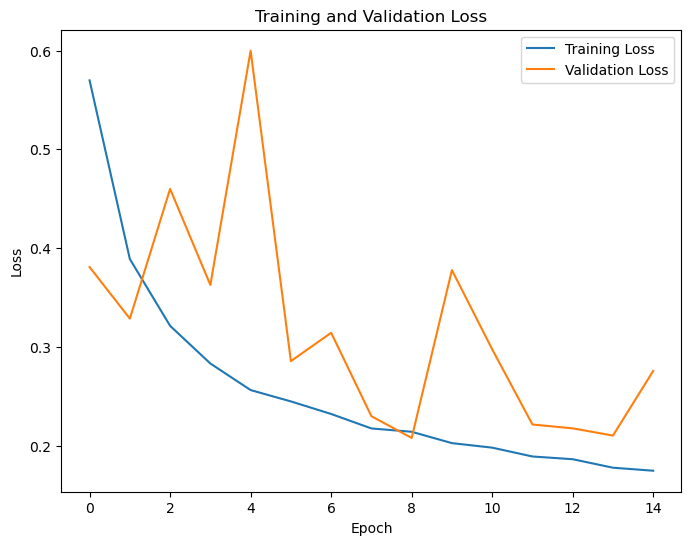

In [18]:
# Plot the training and validation loss vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

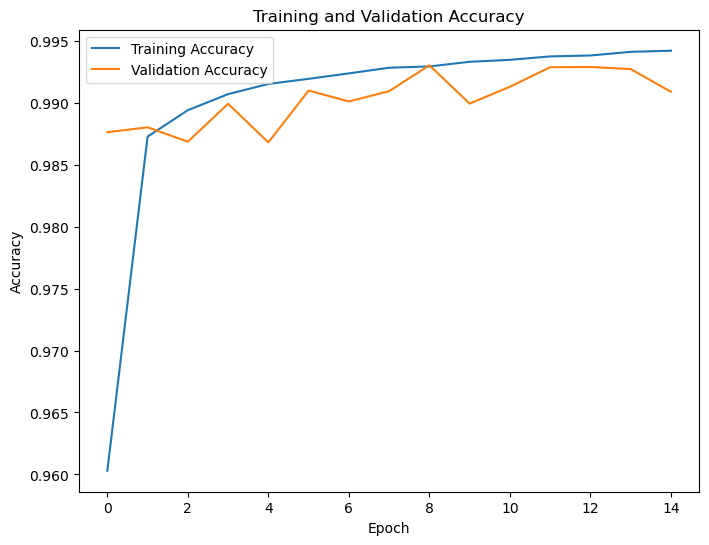

In [19]:
# Plot the training and validation accuracy vs. epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()